In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import s3fs
import os
import gcsfs
from pathlib import Path

In [57]:
OSN_ENDPOINT_URL = "https://nyu1.osn.mghpcc.org"
OSN_BUCKET = "leap-pangeo-manual"
HACKATHON_PREFIX = "hackathon-2026/"
OSN_ROOT = f"s3://{OSN_BUCKET}/{HACKATHON_PREFIX}"

# Conservative bounding box for Soundview neighborhood
LAT_MIN = 40.810  # Southern boundary (Lacombe Ave area)
LAT_MAX = 40.835  # Northern boundary (Cross-Bronx Expressway)

# IMPORTANT: HRRR uses 0-360° longitude (not -180 to 180°)
# Soundview is at -73.875°W to -73.855°W
# Convert to 0-360° system: lon_360 = 360 + lon_negative
LON_MIN = 286.120  # = -73.88°W
LON_MAX = 286.150  # = -73.85°W

# Time range
TIME_START = "2025-01-01"
TIME_END = "2025-12-31"
TREF = pd.Timestamp("2025-01-01 00:00:00")

fs_osn = s3fs.S3FileSystem(
    anon=True,
    client_kwargs={"endpoint_url": OSN_ENDPOINT_URL},
)

# Test: list top-level within the hackathon prefix
fs_osn.ls(f"{OSN_BUCKET}/{HACKATHON_PREFIX}hrrr/tp")[:20]

['leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2020.zarr',
 'leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2021.zarr',
 'leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2022.zarr',
 'leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2023.zarr',
 'leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2024.zarr',
 'leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2025.zarr']

In [58]:
#Example: replace with a real Zarr path you discover via listing
#example_zarr_path = f"{OSN_BUCKET}/{HACKATHON_PREFIX}hrrr/tp/hrrrtp2025.zarr"

#mapper = fs_osn.get_mapper(example_zarr_path)

# Open dataset
#ds = xr.open_zarr(mapper, consolidated=False)  # consolidated=True if metadata consolidated

year_files = [
    # f"{OSN_BUCKET}/{HACKATHON_PREFIX}hrrr/tp/hrrrtp2023.zarr",
    # f"{OSN_BUCKET}/{HACKATHON_PREFIX}hrrr/tp/hrrrtp2024.zarr",
    f"{OSN_BUCKET}/{HACKATHON_PREFIX}hrrr/tp/hrrrtp2025.zarr",
]

datasets = []
for year_path in year_files:
    print(f"Loading {year_path}...")
    mapper = fs_osn.get_mapper(year_path)
    ds_year = xr.open_zarr(mapper, consolidated=False)
    datasets.append(ds_year)

# Concatenate
ds = xr.concat(datasets, dim='time')
print(f"Combined dataset: {ds.dims}")

Loading leap-pangeo-manual/hackathon-2026/hrrr/tp/hrrrtp2025.zarr...
Combined dataset: FrozenMappingWarningOnValuesAccess({'time': 8040, 'y': 1059, 'x': 1799})


In [59]:
# Check the tp variable attributes
print("="*60)
print("Precipitation variable info:")
print("="*60)
print(ds['tp'])
print("\nAttributes:")
for key, value in ds['tp'].attrs.items():
    print(f"  {key}: {value}")

Precipitation variable info:
<xarray.DataArray 'tp' (time: 8040, y: 1059, x: 1799)> Size: 61GB
dask.array<open_dataset-tp, shape=(8040, 1059, 1799), dtype=float32, chunksize=(24, 1059, 1799), chunktype=numpy.ndarray>
Coordinates:
  * time                 (time) datetime64[ns] 64kB 2025-01-01 ... 2025-12-01...
    gribfile_projection  float64 8B ...
    latitude             (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude            (y, x) float64 15MB dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
    valid_time           (time) datetime64[ns] 64kB dask.array<chunksize=(24,), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes: (12/39)
    GRIB_paramId:                             228228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1905141
    GRIB_typeOfLevel:                         surface
   

In [60]:
# Get lat/lon coordinates
lat = ds['latitude']
lon = ds['longitude']

print(f"Original grid shape: {lat.shape}")

# Load just the coordinates (small arrays)
lat_values = lat.values
lon_values = lon.values

print(f"Lat range: [{lat_values.min()}, {lat_values.max()}]")
print(f"Lon range: [{lon_values.min()}, {lon_values.max()}]")

# Find the bounding indices
# HRRR has lat/lon as 2D arrays (y, x)
# Find y indices where any longitude is in range
y_mask = np.any(
    (lat_values >= LAT_MIN) & (lat_values <= LAT_MAX) &
    (lon_values >= LON_MIN) & (lon_values <= LON_MAX),
    axis=1
)
y_indices = np.where(y_mask)[0]

# Find x indices where any latitude is in range  
x_mask = np.any(
    (lat_values >= LAT_MIN) & (lat_values <= LAT_MAX) &
    (lon_values >= LON_MIN) & (lon_values <= LON_MAX),
    axis=0
)
x_indices = np.where(x_mask)[0]

print("\nSubset index ranges:")
print(f"  y: {y_indices.min()} to {y_indices.max()} (out of {lat.shape[0]})")
print(f"  x: {x_indices.min()} to {x_indices.max()} (out of {lat.shape[1]})")

# Slice the dataset using the bounding box
ds_soundview = ds.isel(
    y=slice(y_indices.min(), y_indices.max() + 1),
    x=slice(x_indices.min(), x_indices.max() + 1)
)

# Now apply precise mask within the subset (much smaller data)
lat_subset = ds_soundview['latitude']
lon_subset = ds_soundview['longitude']

precise_mask = (
    (lat_subset >= LAT_MIN) & (lat_subset <= LAT_MAX) &
    (lon_subset >= LON_MIN) & (lon_subset <= LON_MAX)
)

# This mask is smaller and can be computed
precise_mask_computed = precise_mask.compute()

print(f"\nSubset grid shape: {ds_soundview['latitude'].shape}")
print(f"Cells in bounding box: {precise_mask_computed.sum()}")

Original grid shape: (1059, 1799)
Lat range: [21.138123000000004, 52.61565330680793]
Lon range: [225.90452026573686, 299.0828072281622]

Subset index ranges:
  y: 700 to 700 (out of 1059)
  x: 1555 to 1555 (out of 1799)

Subset grid shape: (1, 1)
Cells in bounding box: <xarray.DataArray ()> Size: 8B
array(1)
Coordinates:
    gribfile_projection  float64 8B nan
    step                 timedelta64[ns] 8B 01:00:00
    surface              float64 8B 0.0


In [62]:
# Average over the Soundview area using the precise mask
# Apply mask to set non-Soundview cells to NaN, then take mean ignoring NaN
ds_masked = ds_soundview.where(precise_mask_computed)

# Calculate max over spatial dimensions (skipping NaN values)
rain_max = ds_masked['tp'].max(dim=['y', 'x'], skipna=True)

print(f"Time series length: {len(rain_max.time)}")
print(f"Time range: {rain_max.time.min().values} to {rain_max.time.max().values}")

# Load to compute statistics (small array now)
rain_values = rain_max.compute()

print("\nPrecipitation statistics:")
print(f"  Mean: {rain_values.mean().values:.3f}")
print(f"  Max: {rain_values.max().values:.3f}")
print(f"  Min: {rain_values.min().values:.3f}")
print(f"  Std: {rain_values.std().values:.3f}")

Time series length: 8040
Time range: 2025-01-01T00:00:00.000000000 to 2025-12-01T23:00:00.000000000

Precipitation statistics:
  Mean: 0.090
  Max: 28.504
  Min: 0.000
  Std: 0.695


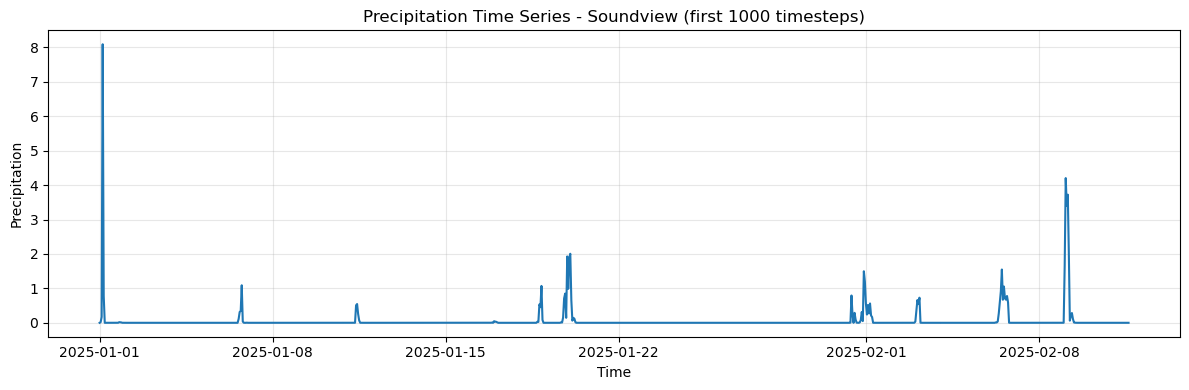


Rain event statistics:
  % of time with rain: 13.8%
  Mean when raining: 0.649
  Max intensity: 28.504


In [63]:
import matplotlib.pyplot as plt

# rain_values is already computed from Cell 5
# Plot first 1000 timesteps
plt.figure(figsize=(12, 4))
plt.plot(rain_values.time[:1000].values, rain_values.values[:1000])
plt.title('Precipitation Time Series - Soundview (first 1000 timesteps)')
plt.ylabel('Precipitation')
plt.xlabel('Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also show some event statistics
non_zero = rain_values.values[rain_values.values > 0]
print(f"\nRain event statistics:")
print(f"  % of time with rain: {len(non_zero) / len(rain_values) * 100:.1f}%")
print(f"  Mean when raining: {non_zero.mean():.3f}")
print(f"  Max intensity: {non_zero.max():.3f}")

In [50]:
# rain_values is already computed from Cell 5
# Calculate time in seconds since reference time
time_seconds = (rain_values.time - np.datetime64(TREF)).dt.total_seconds()

# Create dataframe
df = pd.DataFrame({
    'time_sec': time_seconds.values,
    'precip_mm_hr': rain_values.values  # VERIFY UNITS IN CELL 3!
})

# Remove NaN
df = df.dropna()

print(f"Number of timesteps: {len(df)}")
print(f"Time range: {df['time_sec'].min():.0f} to {df['time_sec'].max():.0f} seconds")
print(f"Duration: {(df['time_sec'].max() - df['time_sec'].min()) / 86400:.1f} days")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLast few rows:")
print(df.tail())

Number of timesteps: 25582
Time range: 0 to 92098800 seconds
Duration: 1066.0 days

First few rows:
   time_sec  precip_mm_hr
0       0.0         0.347
1    3600.0         0.855
2    7200.0         1.710
3   10800.0         3.772
4   14400.0         0.033

Last few rows:
         time_sec  precip_mm_hr
25579  92084400.0           0.0
25580  92088000.0           0.0
25581  92091600.0           0.0
25582  92095200.0           0.0
25583  92098800.0           0.0


Quality Checks:
----------------------------------------
Negative values: 0
Extreme values (>100 mm/hr): 0
Non-monotonic time steps: 0


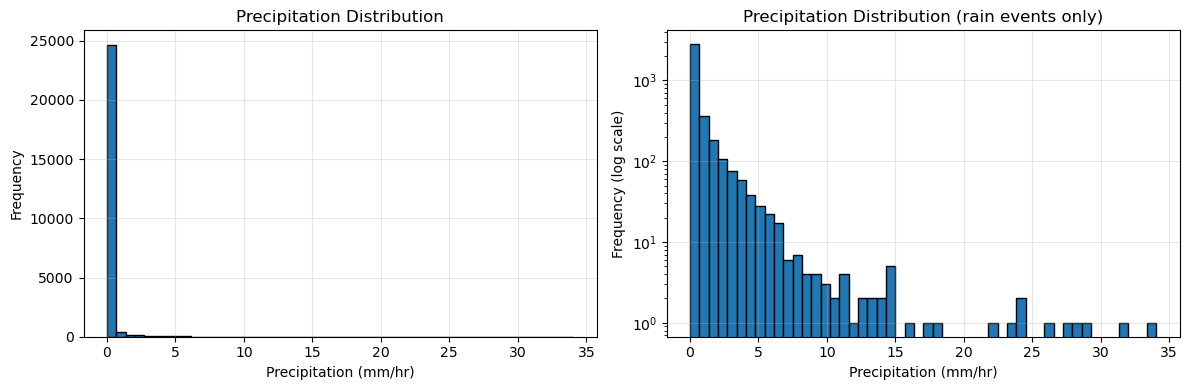

In [52]:
# Check for issues
print("Quality Checks:")
print("-" * 40)

# Negative values
neg_count = (df['precip_mm_hr'] < 0).sum()
print(f"Negative values: {neg_count}")

# Extreme values
extreme_count = (df['precip_mm_hr'] > 100).sum()
print(f"Extreme values (>100 mm/hr): {extreme_count}")

# Time monotonicity
time_diffs = df['time_sec'].diff()
non_monotonic = (time_diffs < 0).sum()
print(f"Non-monotonic time steps: {non_monotonic}")

# Plot histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(df['precip_mm_hr'], bins=50, edgecolor='black')
ax1.set_xlabel('Precipitation (mm/hr)')
ax1.set_ylabel('Frequency')
ax1.set_title('Precipitation Distribution')
ax1.grid(True, alpha=0.3)

# Log scale for better view of rain events
ax2.hist(df['precip_mm_hr'][df['precip_mm_hr'] > 0], bins=50, edgecolor='black')
ax2.set_xlabel('Precipitation (mm/hr)')
ax2.set_ylabel('Frequency (log scale)')
ax2.set_yscale('log')
ax2.set_title('Precipitation Distribution (rain events only)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
# Write to temp file
local_output = "/tmp/sfincs.precip"
df.to_csv(local_output, sep=' ', index=False, header=False, float_format='%.6f')

print(f"✓ Wrote {len(df)} timesteps to {local_output}")

# Show first few lines
with open(local_output, 'r') as f:
    print("\nFirst 5 lines of output file:")
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())

✓ Wrote 25582 timesteps to /tmp/sfincs.precip

First 5 lines of output file:
0.000000 0.347000
3600.000000 0.855000
7200.000000 1.710000
10800.000000 3.772000
14400.000000 0.033000


In [54]:
# Setup GCS
fs_gcs = gcsfs.GCSFileSystem()

def gcs_upload(local_path, gs_url):
    assert gs_url.startswith("gs://")
    rel = gs_url.replace("gs://", "")
    with open(local_path, "rb") as fsrc:
        with fs_gcs.open(rel, "wb") as fdst:
            fdst.write(fsrc.read())
    return gs_url

# Upload
OUT_PREFIX = f"{SCRATCH_BUCKET.rstrip('/')}/sfincs_soundview_preproc"
gcs_path = f"{OUT_PREFIX}/forcing/sfincs.precip"

gcs_upload(local_output, gcs_path)
print(f"✓ Uploaded to {gcs_path}")

✓ Uploaded to gs://leap-scratch/zero734kr/sfincs_soundview_preproc/forcing/sfincs.precip
